# Gaussians Arithmetic

This is a presentation for Computer Science Club having to do with Kalman filters.  

## Basic Gaussian Generation And Plotting 

In [3]:
import csv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


class Plot:
    def __init__(self, range=(-20,20)):
        self.range = range 
    
    def hist(self, data, color):
        plt.hist(data, 200, range=self.range, normed=1, facecolor=color, alpha=0.5, histtype='stepfilled')

    def show(self):
        plt.show() 
        
        
class Gaussian:
    def generate(self, params, samples=2000):
        self.data = []
        for i in range(samples):
            self.data.append(np.random.normal(params[0], params[1]))
     
    def plot_hist(self, plot, color='green'):
        plot.hist(self.data, color)


### Plotting A Single Gaussian

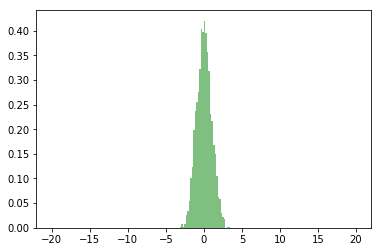

In [4]:
p = Plot()
    
g1 = Gaussian()
g1.generate((0.0, 1.0))
g1.plot_hist(p)

p.show() 

### Plotting Multiple Gaussians

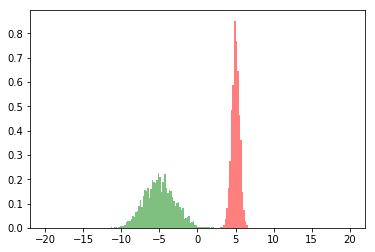

In [5]:
p = Plot()
    
g1 = Gaussian()
g1.generate((-5.0, 2.0))
g1.plot_hist(p, 'green')

g2 = Gaussian()
g2.generate((5, 0.5))
g2.plot_hist(p, 'red')

p.show() 

## Computing With Gaussian Distributions

In [28]:
class Compute:
    def predict(self, dist1, dist2):
        mean = dist1[0] + dist2[0]
        std = dist1[1] + dist2[1]
        self.dist = (mean, std)
        
    def measure(self, dist1, dist2):
        mean = (dist1[0] * dist2[1] + dist1[1] * dist2[0]) / (dist1[1] + dist2[1])
        std = 1.0 / (1.0 / dist1[1] + 1.0 / dist2[1])
        self.dist = (mean, std)
   

### Prediction Step

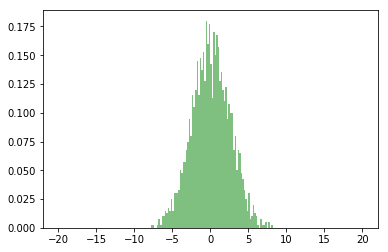

In [29]:
measurement = (-5.0, 2.0)
prediction = (5, 0.5)

c = Compute()
c.predict(measurement, prediction)

p = Plot()

g = Gaussian()
g.generate(c.dist)
g.plot_hist(p)

p.show() 

### Measurement Step

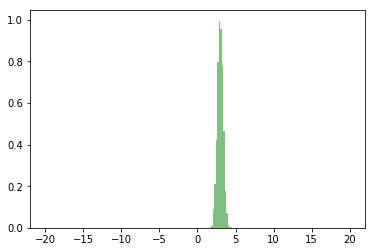

In [30]:
prior = (-5.0, 2.0)
measurement = (5, 0.5)

c = Compute()
c.measure(prior, measurement)

p = Plot()

g = Gaussian()
g.generate(c.dist)
g.plot_hist(p)

p.show() 